In [1]:
%load_ext autoreload
%autoreload 2
import os
from encoding_information.gpu_utils import limit_gpu_memory_growth  
limit_gpu_memory_growth()
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from resolution1d_utils import *
from tqdm import tqdm

Rayleigh distance: 400.0 nm


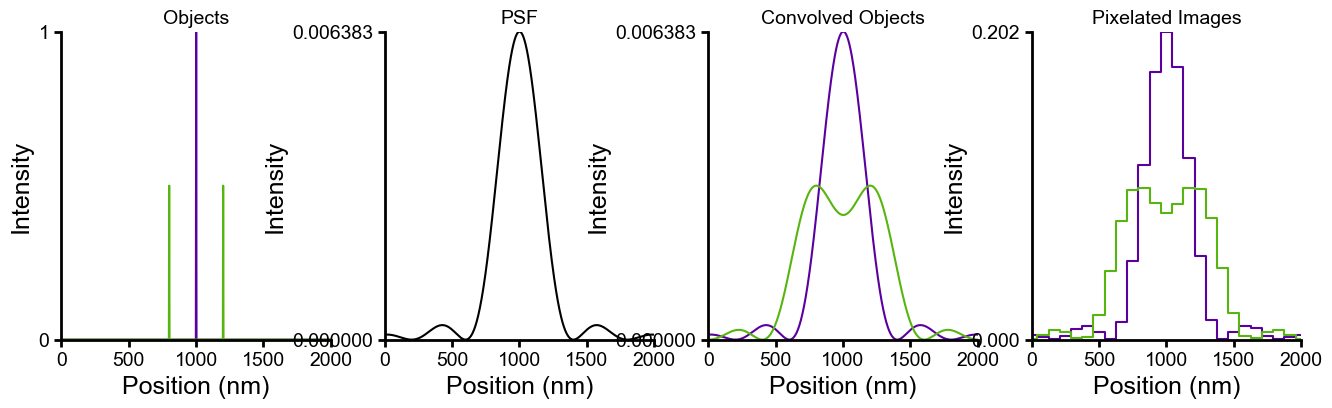

In [2]:
wavelength = 400 # nm
NA = .5
pixel_size = 80 # nm
size = 2000 # nm
num_pixels = int(size / pixel_size)
seperation_distance = 400 # nm

rayleigh_dist = wavelength / (2 * 0.5)
seperation_distance = rayleigh_dist
print(f"Rayleigh distance: {rayleigh_dist} nm")

(one_point_object, two_point_object, one_point_convolved, two_point_convolved, one_point_noiseless_pixels, two_point_noiseless_pixels,
  x, PSF) = simulate_optics(wavelength, NA, size, seperation_distance, pixel_size)


###### Make plots ###### 
# plot both objects
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].plot(x, one_point_object, get_color_cycle()[1])
ax[0].plot(x, two_point_object, get_color_cycle()[3])
ax[0].set(title='Objects', xlim=(x.min(), x.max()), ylim=(0, 1), yticks=[0, 1], xlabel='Position (nm)', ylabel='Intensity')

# plot the PSF
ax[1].plot(x, PSF, 'k-')
ax[1].set(title='PSF', xlim=(x.min(), x.max()), ylim=(0, PSF.max()), yticks=[0, PSF.max()], xlabel='Position (nm)', ylabel='Intensity')

# plot the convolved objects
ax[2].plot(x, one_point_convolved, get_color_cycle()[1])
ax[2].plot(x, two_point_convolved, get_color_cycle()[3])
ax[2].set(title='Convolved Objects', xlim=(x.min(), x.max()), ylim=(0, one_point_convolved.max()), 
          yticks=[0, one_point_convolved.max()], xlabel='Position (nm)', ylabel='Intensity')


# plot pixelated images
ax[3].plot(np.linspace(0, num_pixels * pixel_size, num_pixels), one_point_noiseless_pixels, drawstyle='steps-mid', color=get_color_cycle()[1])
ax[3].plot(np.linspace(0, num_pixels * pixel_size, num_pixels), two_point_noiseless_pixels, drawstyle='steps-mid', color=get_color_cycle()[3])
ax[3].set(title='Pixelated Images', xlim=(0, size), ylim=(0, one_point_noiseless_pixels.max()), 
          yticks=[0, one_point_noiseless_pixels.max()], xlabel='Position (nm)', ylabel='Intensity')

_ = [clear_spines(ax[i]) for i in range(len(ax))]

plt.gcf().savefig('/home/hpinkard_waller/figures/1d_signals/' + f'2_point_intro' + '.pdf', transparent=True)

# Estimate the MI of noisy measurements

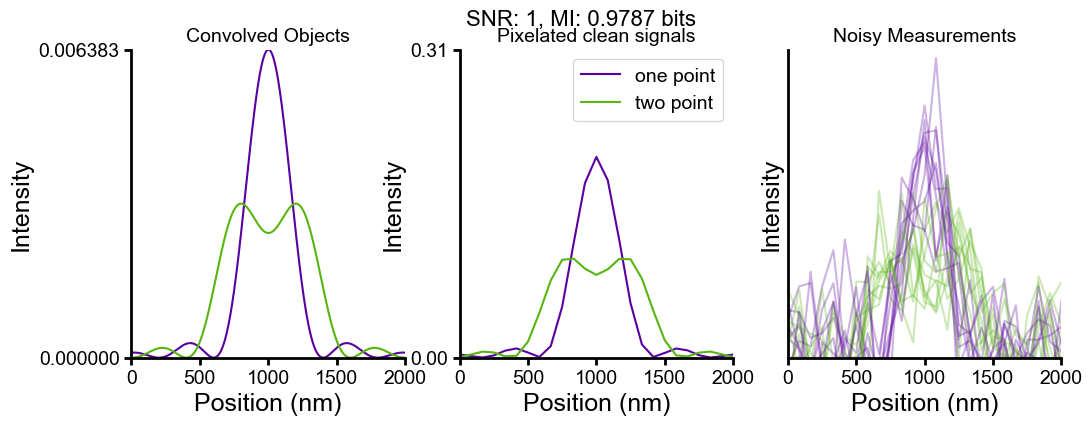

In [3]:
num_measurements = int(1e6)
snr = 1
num_measurements_to_display = 10

mi = estimate_2_point_1_point_mi(one_point_noiseless_pixels, two_point_noiseless_pixels, snr=snr, num_measurements=num_measurements)

make_signal_and_measurement_plot(one_point_convolved, two_point_convolved, one_point_noiseless_pixels, two_point_noiseless_pixels, x, snr, 
                                 alpha=0.3, num_measurements=num_measurements_to_display, show_pixelated=False)
plt.gcf().suptitle(f'SNR: {snr}, MI: {mi:.4f} bits', fontsize=16)

plt.gcf().savefig('/home/hpinkard_waller/figures/1d_signals/' + f'2_point_intro_noisy' + '.pdf', transparent=True)


In [26]:
num_measurements = int(1e6)    

gaussian_noise_sigma = 1 / (snr * one_point_noiseless_pixels.size)
num_pixels = one_point_noiseless_pixels.size
noisy_one_point_measurements = get_noisy_measurements(one_point_noiseless_pixels, snr, num_measurements // 2)
noisy_two_point_measurements = get_noisy_measurements(two_point_noiseless_pixels, snr, num_measurements // 2)

from encoding_information.information_estimation import estimate_mutual_information

bias = 40
scale = 300

photon_sigma = gaussian_noise_sigma * scale
photon_measurements_one_point = noisy_one_point_measurements * scale + bias
photon_measurements_two_point = noisy_two_point_measurements * scale + bias

all_measurements = onp.concatenate([photon_measurements_one_point, photon_measurements_two_point])
# shuffle them
# onp.random.shuffle(all_measurements)
# all_measurements = np.array(all_measurements)
all_measurements = all_measurements.reshape(-1, int(np.sqrt(all_measurements.shape[-1])), int(np.sqrt(all_measurements.shape[-1])))

mi, pcnn = estimate_mutual_information(all_measurements, return_entropy_model=True, max_epochs=10,
                                 entropy_model='pixelcnn', gaussian_noise_sigma=photon_sigma, verbose=True)
total_mi = mi * num_pixels
print(total_mi)

samples = pcnn.generate_samples(10).reshape(-1, num_pixels)

samples -= bias
samples /= scale

all_measurements -= bias
all_measurements /= scale
all_measurements = all_measurements.reshape(-1, num_pixels)

/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:303: UserWarning: 0.02% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


Initial validation NLL: 6.98


Epoch 1: 100%|██████████| 100/100 [00:03<00:00, 29.46it/s]


Epoch 1: validation NLL: 3.98


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 170.72it/s]


Epoch 2: validation NLL: 3.97


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 152.11it/s]


Epoch 3: validation NLL: 3.95


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 156.76it/s]


Epoch 4: validation NLL: 3.95


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 167.83it/s]


Epoch 5: validation NLL: 3.95


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 160.41it/s]


Epoch 6: validation NLL: 3.96


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 169.95it/s]


Epoch 7: validation NLL: 3.95


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 167.69it/s]


Epoch 8: validation NLL: 3.95


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 162.96it/s]


Epoch 9: validation NLL: 3.95


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 170.41it/s]


Epoch 10: validation NLL: 3.95
Estimated H(Y|X) = 3.904 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.950 differential entropy/pixel
Estimated I(Y;X) = 0.066 bits/pixel
1.6477916


Generating PixelCNN samples: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


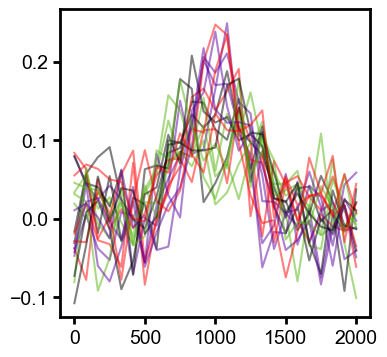

In [25]:
# plot 5 noisy one point measurements, 5 noisy two point measurements, and 5 samples
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
for i in range(5):
    ax.plot(np.linspace(0, size, num_pixels), noisy_one_point_measurements[i], color=get_color_cycle()[1], alpha=0.5)
    ax.plot(np.linspace(0, size, num_pixels), noisy_two_point_measurements[i],  color=get_color_cycle()[3], alpha=0.5)
    ax.plot(np.linspace(0, size, num_pixels), samples[i], color='k', alpha=0.5)
    ax.plot(np.linspace(0, size, num_pixels), all_measurements[i], color='r', alpha=0.5)

Generating PixelCNN samples: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


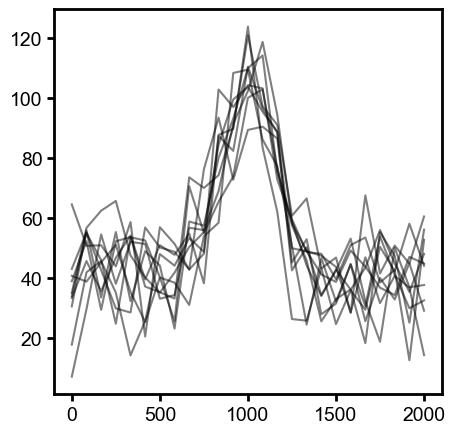

In [17]:

# plot the samples
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(np.linspace(0, size, num_pixels), samples.T, color='k', alpha=0.5)

### Sample size vs estimate
How big of samples are needed to get accurate results

100%|██████████| 10/10 [00:24<00:00,  2.42s/it]


Estimated MI: 0.994 bits


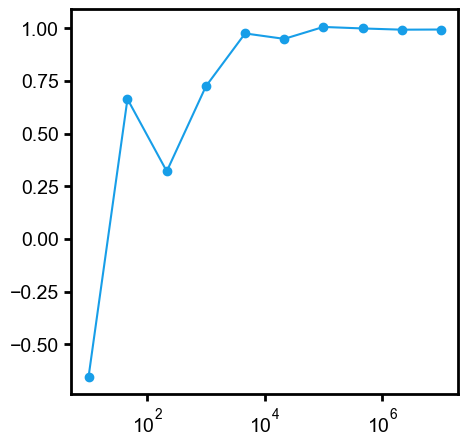

In [4]:
# Look at sample size dependence of estimate
nums_to_use = np.logspace(1, 7, 10, base=10).astype(int)
mis = []

for num_to_use in tqdm(nums_to_use):
    mi = estimate_2_point_1_point_mi(one_point_noiseless_pixels, two_point_noiseless_pixels, snr, num_measurements=num_to_use)
    mis.append(mi)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.semilogx(nums_to_use, mis, 'o-')

print(f"Estimated MI: {mi:.3f} bits")

## Do Information vs SNR and NA



In [8]:
# SNRs = np.linspace(2, 0.1, 20)
SNRs = np.logspace(-2, 1, 40)
NAs = np.linspace(0.1, 1, 40) 

num_measurements = int(5e5)

wavelength = 400 # nm
pixel_size = 80 # nm
size = 5000 # nm
num_pixels = int(size / pixel_size)
seperation_distance =  wavelength / (2 * 0.5) # rayleigh distance for NA = 0.5


results = onp.zeros((len(SNRs), len(NAs)))
for i, snr in tqdm(enumerate(SNRs), total=len(SNRs)):
    for j, na in enumerate(NAs):
        (one_point_object, two_point_object, one_point_convolved, two_point_convolved, one_point_noiseless_pixels, two_point_noiseless_pixels,
          x, PSF) = simulate_optics(wavelength, na, size, seperation_distance, pixel_size=pixel_size)
        mi = estimate_2_point_1_point_mi(one_point_noiseless_pixels, two_point_noiseless_pixels, snr, num_measurements=num_measurements)
        results[i, j] = mi

results = np.array(results)

100%|██████████| 40/40 [07:59<00:00, 11.98s/it]


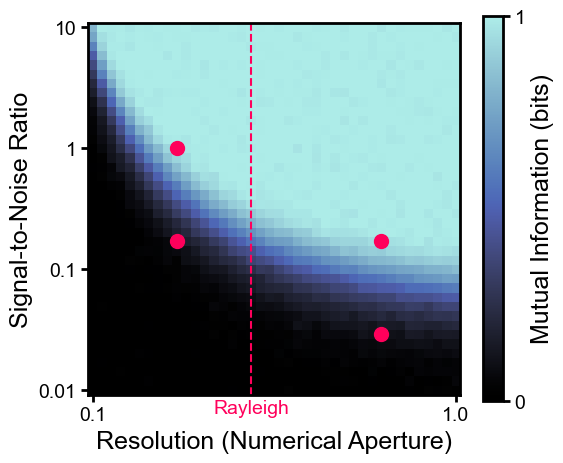

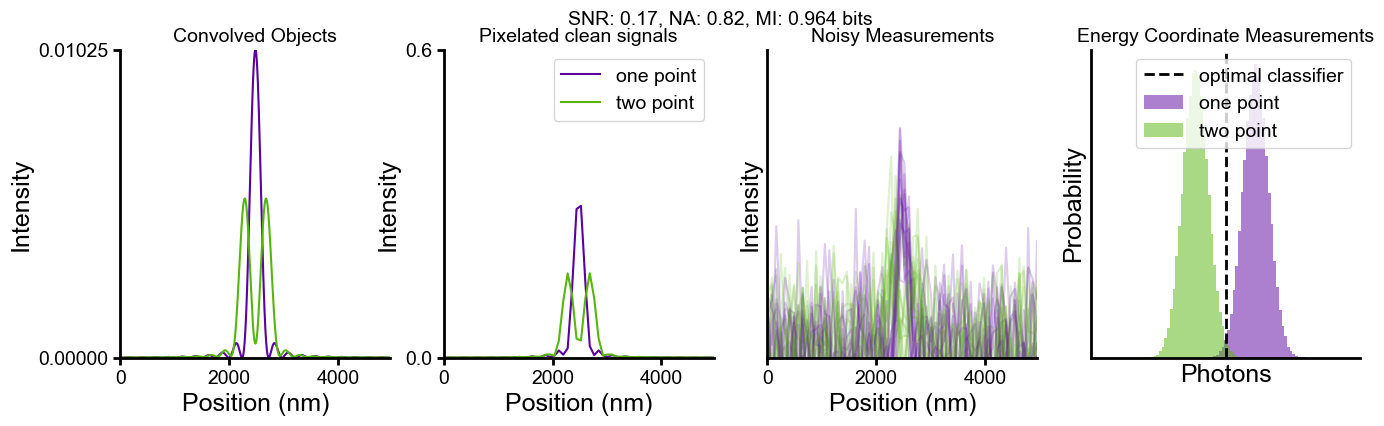

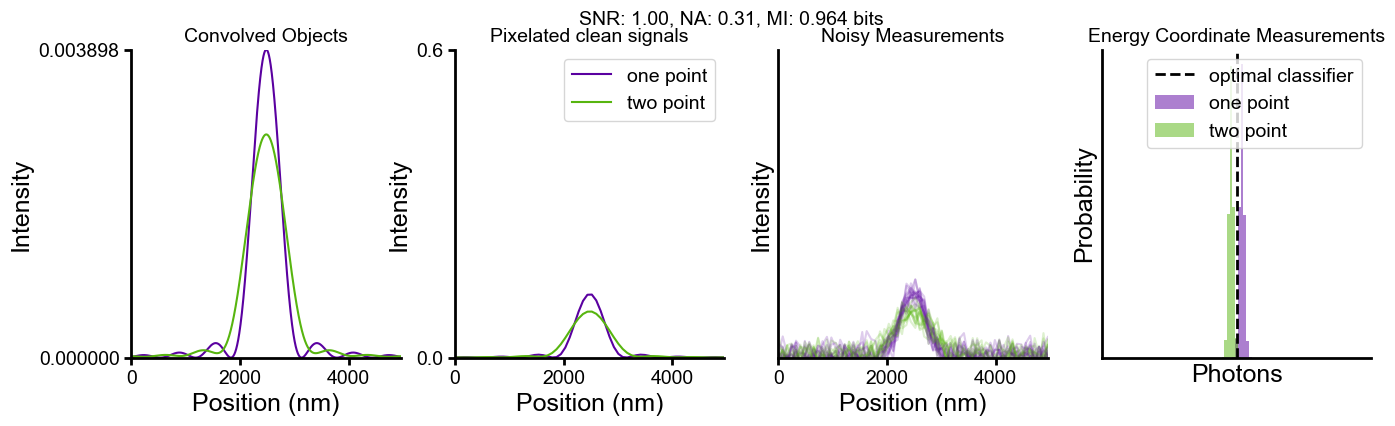

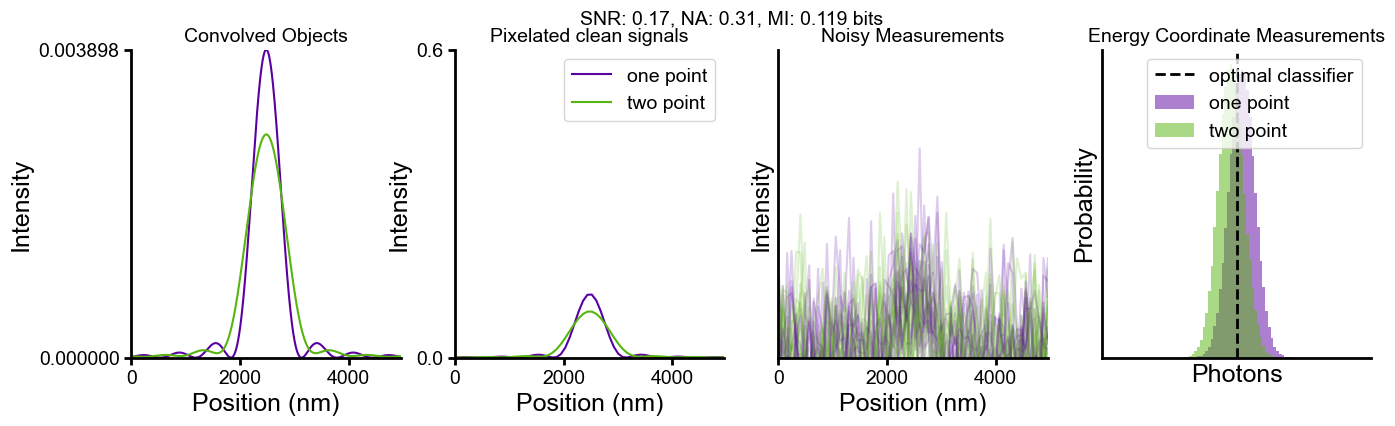

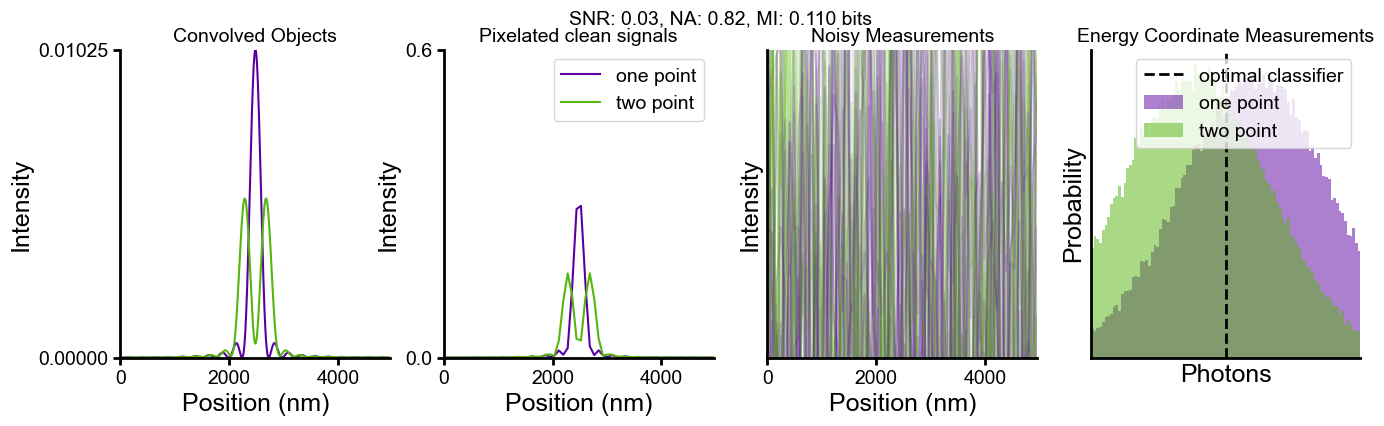

In [13]:
show_pixelated = False
num_noisy_measurements_to_display = 14
alpha = 0.2


num_distribution_measurements = 100000
y_max = 0.6
project_to_optimal = True


import cmasher as cmr
from matplotlib.ticker import LogLocator, LogFormatter

cmap = cmr.sapphire
red = get_color_cycle()[2]

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
cax = ax.imshow(results, cmap=cmap, origin='lower', vmin=0, vmax=1,)
            #      extent=[NAs[0], NAs[-1], SNRs[0], SNRs[-1]],
            # aspect= (NAs[-1] - NAs[0]) / (SNRs[-1] - SNRs[0]))
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('Mutual Information (bits)')
# set color bar labels to 0, 1
cbar.set_ticks([0, 1])

# make a ytick for every power of 10 in SNRs
ytick_labels = [ str(10**i) for i in range(int(np.log10(SNRs[0])), int(np.log10(SNRs[-1])) + 1)]

_ = ax.set(xlabel='Resolution (Numerical Aperture)', ylabel='Signal-to-Noise Ratio',
        xticks=[0, len(NAs) - 1], xticklabels=[NAs[0], NAs[-1]],
        yticks= np.linspace(0, len(SNRs) - 1, len(ytick_labels)), yticklabels=ytick_labels)


def add_point(SNR_value, NA_value):
        # Find the indices from the values, this is necessary for simulation and result extraction
        SNR_index = np.argmin(np.abs(SNRs - SNR_value))
        NA_index = np.argmin(np.abs(NAs - NA_value))

        # now replace the values with the ones we have data for
        SNR_value = SNRs[SNR_index]
        NA_value = NAs[NA_index]

        # Retrieve simulation details using indices if necessary
        (one_point_object, two_point_object, one_point_convolved, two_point_convolved, 
        one_point_noiseless_pixels, two_point_noiseless_pixels, x, PSF) = simulate_optics(wavelength, NA_value, size,
                                                                                        seperation_distance, pixel_size)
        
        make_signal_and_measurement_plot(one_point_convolved, two_point_convolved, one_point_noiseless_pixels, 
                                        two_point_noiseless_pixels, x, SNR_value,
                                        show_pixelated=show_pixelated, num_measurements=num_noisy_measurements_to_display, alpha=alpha,
                                        energy_coord_measurements=num_distribution_measurements, y_max=y_max, projection_vector=project_to_optimal)
                                        

        plt.gcf().suptitle(f"SNR: {SNR_value:.2f}, NA: {NA_value:.2f}, MI: {results[SNR_index, NA_index]:.3f} bits", fontsize=14)

        # Plot the point using the actual SNR and NA values
        ax.plot(NA_index, SNR_index, 'o', markersize=10, color=red)
        return results[SNR_index, NA_index]


def find_point_within_limits(mi_limits, na_limits):
        NA_grid, SNR_grid = np.meshgrid(NAs, SNRs)

        search_space = results.copy()
        
        if na_limits[0] is not None:
                search_space[NA_grid < na_limits[0]] = np.nan
        if na_limits[1] is not None:
                search_space[NA_grid > na_limits[1]] = np.nan
        
        if mi_limits[0] is not None:
                search_space[results < mi_limits[0]] = np.nan
        if mi_limits[1] is not None:
                search_space[results > mi_limits[1]] = np.nan

        # find the lowest SNR combo that meets the criteria
        SNR_grid[np.isnan(search_space)] = np.nan
        max_index = np.nanargmin(SNR_grid)
        max_index = np.unravel_index(max_index, search_space.shape)
        mi = add_point(SNR_value=SNRs[max_index[0]], NA_value=NAs[max_index[1]])
        return SNRs[max_index[0]], NAs[max_index[1]], mi


# compute NA that gives the Rayleigh distance for this seperation distance
rayleigh_na = wavelength / (2 * seperation_distance)
# make a dotted line at the Rayleigh NA
ax.axvline(np.argmin(np.abs(NAs - rayleigh_na)), color=red, linestyle='--')
# add label on the x axis
ax.text(np.argmin(np.abs(NAs - rayleigh_na)), -1, f'Rayleigh', color=red, ha='center', va='top')



### Find points to plot


snr1, na1, mi1 = find_point_within_limits(mi_limits=(0.95, 1), na_limits=(0.8, .9))
plt.gcf().savefig('/home/hpinkard_waller/figures/1d_signals/' + f'2_point_representative_signals_1' + '.pdf', transparent=True)

snr2, na2, mi2 = find_point_within_limits(mi_limits=(0.95, 1), na_limits=(0.25, 0.35))
plt.gcf().savefig('/home/hpinkard_waller/figures/1d_signals/' + f'2_point_representative_signals_2' + '.pdf', transparent=True)

mi3 = add_point(snr1, na2)
plt.gcf().savefig('/home/hpinkard_waller/figures/1d_signals/' + f'2_point_representative_signals_3' + '.pdf', transparent=True)

find_point_within_limits(mi_limits=(mi3 - .03, mi3 + 0.03), na_limits=(na1 - 0.02, na1 + 0.02))
plt.gcf().savefig('/home/hpinkard_waller/figures/1d_signals/' + f'2_point_representative_signals_4' + '.pdf', transparent=True)

fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'2_point_snr_resolution_info' + '.pdf', transparent=True)


## Plot optimal classifier performance vs information

In [58]:
from scipy.stats import norm

def get_info_and_best_classifier(num_dimesnions, sigma, mean_difference, num_measurements=int(1e7)):
    """
    Assuming additive white Gaussian noise, both the informaiton content and the best classifier are known
    """
    normalized_difference = mean_difference / sigma
    # take normal cdf
    best_classifier_acc = norm.cdf(normalized_difference / 2)

    # Compute information
    means = [onp.zeros(num_dimesnions), onp.zeros(num_dimesnions)]
    means[1][0] = mean_difference
    covs = [np.eye(num_dimesnions) * sigma**2 for _ in means]
    weights = np.array([0.5, 0.5])

    hy_mid_x = (0.5 * np.log(2 * np.pi * np.e * sigma**2)) * num_pixels
    all_measurements = sigma * jax.random.normal(jax.random.PRNGKey(onp.random.randint(10000)), shape=(num_measurements, num_dimesnions))
    # shift half of the measurements by the mean difference along one dimension
    all_measurements = all_measurements.at[num_measurements // 2:, 0].set(all_measurements[num_measurements // 2:, 0] + mean_difference)

    h_y = gmm_mean_nll(all_measurements, means, covs, weights)

    mi = (h_y - hy_mid_x) / np.log(2) # convert to bits

    return  best_classifier_acc, mi
    

mean_diffs = np.linspace(0, 6, 60)
num_pixels = 32

best_accuracies = []
mis = []
for mean_diff in tqdm(mean_diffs):
    best_acc, mi = get_info_and_best_classifier(num_dimesnions=num_pixels, sigma=1, mean_difference=mean_diff)
    best_accuracies.append(best_acc)
    mis.append(mi)


100%|██████████| 60/60 [00:48<00:00,  1.24it/s]


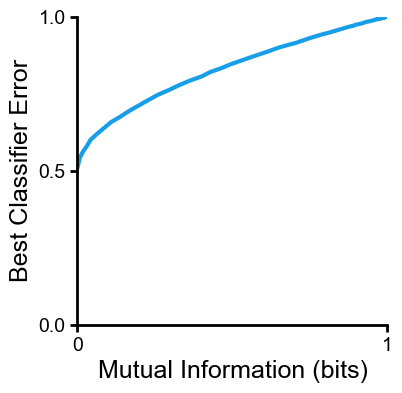

In [59]:

# scatter plot of MI vs best classifier error
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(mis, best_accuracies, '-', linewidth=3)
ax.set(xlabel='Mutual Information (bits)', ylabel='Best Classifier Error', xlim=(0, 1), ylim=(0, 1),
        xticks=[0, 1], yticks=[0, 0.5, 1])
clear_spines(ax)
fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'2_point_mi_vs_classifier_error' + '.pdf', transparent=True)

# # plot seperation dist vs MI
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.plot(mean_diffs, mis, '-o')
# ax.set(xlabel='Mean Difference', ylabel='Mutual Information (bits)', xlim=(0, 6))
# clear_spines(ax)

# # plot seperation dist vs best classifier error
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.plot(mean_diffs, best_accuracies, '-o')
# ax.set(xlabel='Mean Difference', ylabel='Best Classifier Error', xlim=(0, 6), ylim=(0, 1))
# clear_spines(ax)